# Sentiment Analysis

### By Varnica Sharma

## Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-darkgrid")
import nltk
from nltk.sentiment import  SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import torch as pt
from transformers import pipeline
import warnings 
warnings.filterwarnings("ignore")

## Pre-processing the data

In [2]:
df = pd.read_csv("data/Reviews.csv")

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

In [5]:
df = df.head(500)

In [6]:
df.shape

(500, 10)

### Exploratory Data Analysis

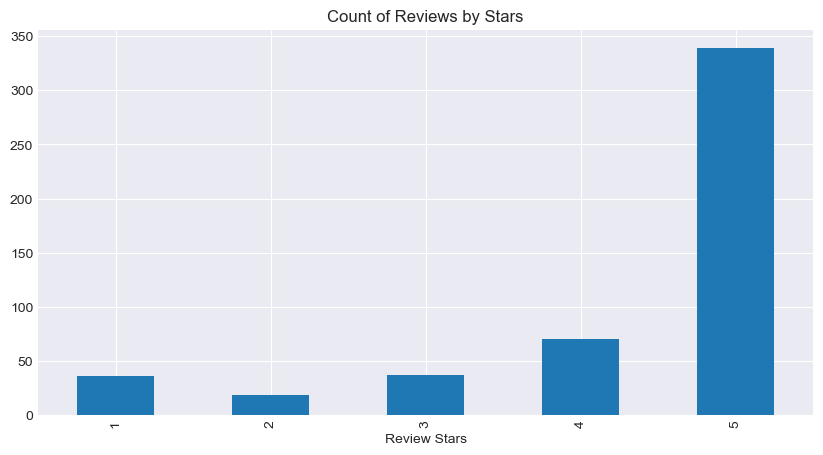

In [7]:
ax = df["Score"].value_counts().sort_index() \
    .plot(kind="bar", 
    title="Count of Reviews by Stars",
    figsize=(10, 5))
ax.set_xlabel("Review Stars")
plt.show()

### Basic NLTK

In [8]:
exp = df["Text"][50]
exp

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [9]:
tokens = nltk.word_tokenize(exp)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [10]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [11]:
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

In [12]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## VADER Sentiment Scoring

In [13]:
# nltk.download('vader_lexicon')

In [14]:
sia = SentimentIntensityAnalyzer()

In [15]:
sia.polarity_scores("I am so happy!")

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [16]:
sia.polarity_scores("This is the worst thing ever.")

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [17]:
sia.polarity_scores(exp)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

### Run the polarity score on the entire dataset

In [18]:
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["Text"]
    myid = row["Id"]
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={"index": "Id"})
vaders = vaders.merge(df, how="left")
vaders

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.000,0.554,0.446,0.9725,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,497,0.059,0.799,0.142,0.7833,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
497,498,0.025,0.762,0.212,0.9848,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
498,499,0.041,0.904,0.055,0.1280,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


## Plotting VADER Results

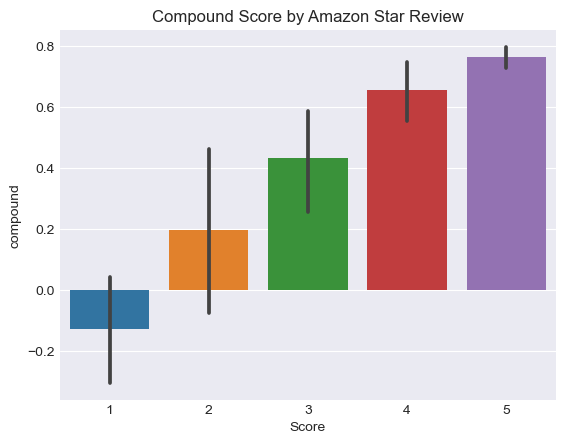

In [20]:
ax = sns.barplot(data=vaders, x="Score", y="compound")
ax.set_title("Compound Score by Amazon Star Review")
plt.show()

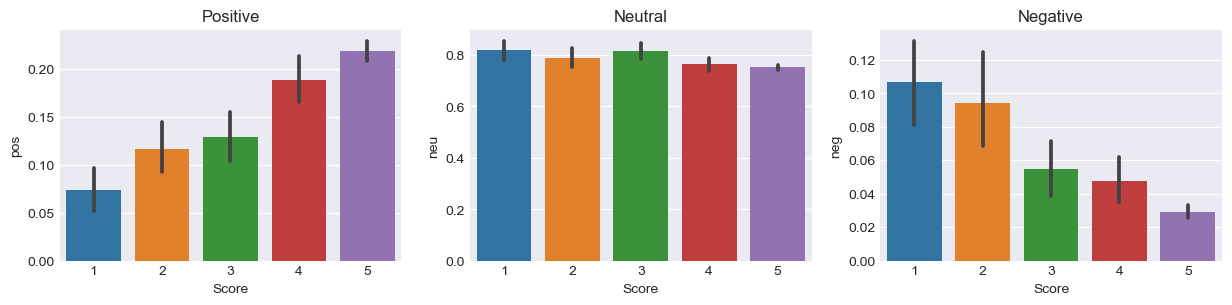

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.barplot(data=vaders, x="Score", y="pos", ax=ax[0])
sns.barplot(data=vaders, x="Score", y="neu", ax=ax[1])
sns.barplot(data=vaders, x="Score", y="neg", ax=ax[2])
ax[0].set_title("Positive")
ax[1].set_title("Neutral")
ax[2].set_title("Negative")
plt.show()

## Roberta Pretrained Model

In [22]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [23]:
encoded_text = tokenizer(exp, return_tensors="pt")
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
scores_dict

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687481,
 'roberta_pos': 0.002957372}

In [24]:
def polarity_scores_roberta(exp):
    encoded_text = tokenizer(exp, return_tensors="pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [25]:
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row["Text"]
        myid = row["Id"]
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        results[myid] = both
    except RuntimeError:
        print(f"Broke for id {myid}")

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [26]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={"index": "Id"})
results_df = results_df.merge(df, how="left")
results_df

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452413,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,496,0.000,0.554,0.446,0.9725,0.001906,0.009862,0.988232,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
494,497,0.059,0.799,0.142,0.7833,0.004415,0.034215,0.961369,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
495,498,0.025,0.762,0.212,0.9848,0.006427,0.074537,0.919036,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
496,499,0.041,0.904,0.055,0.1280,0.865614,0.119366,0.015020,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


In [27]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452413,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Combining & Comparing Scores between Models

In [28]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

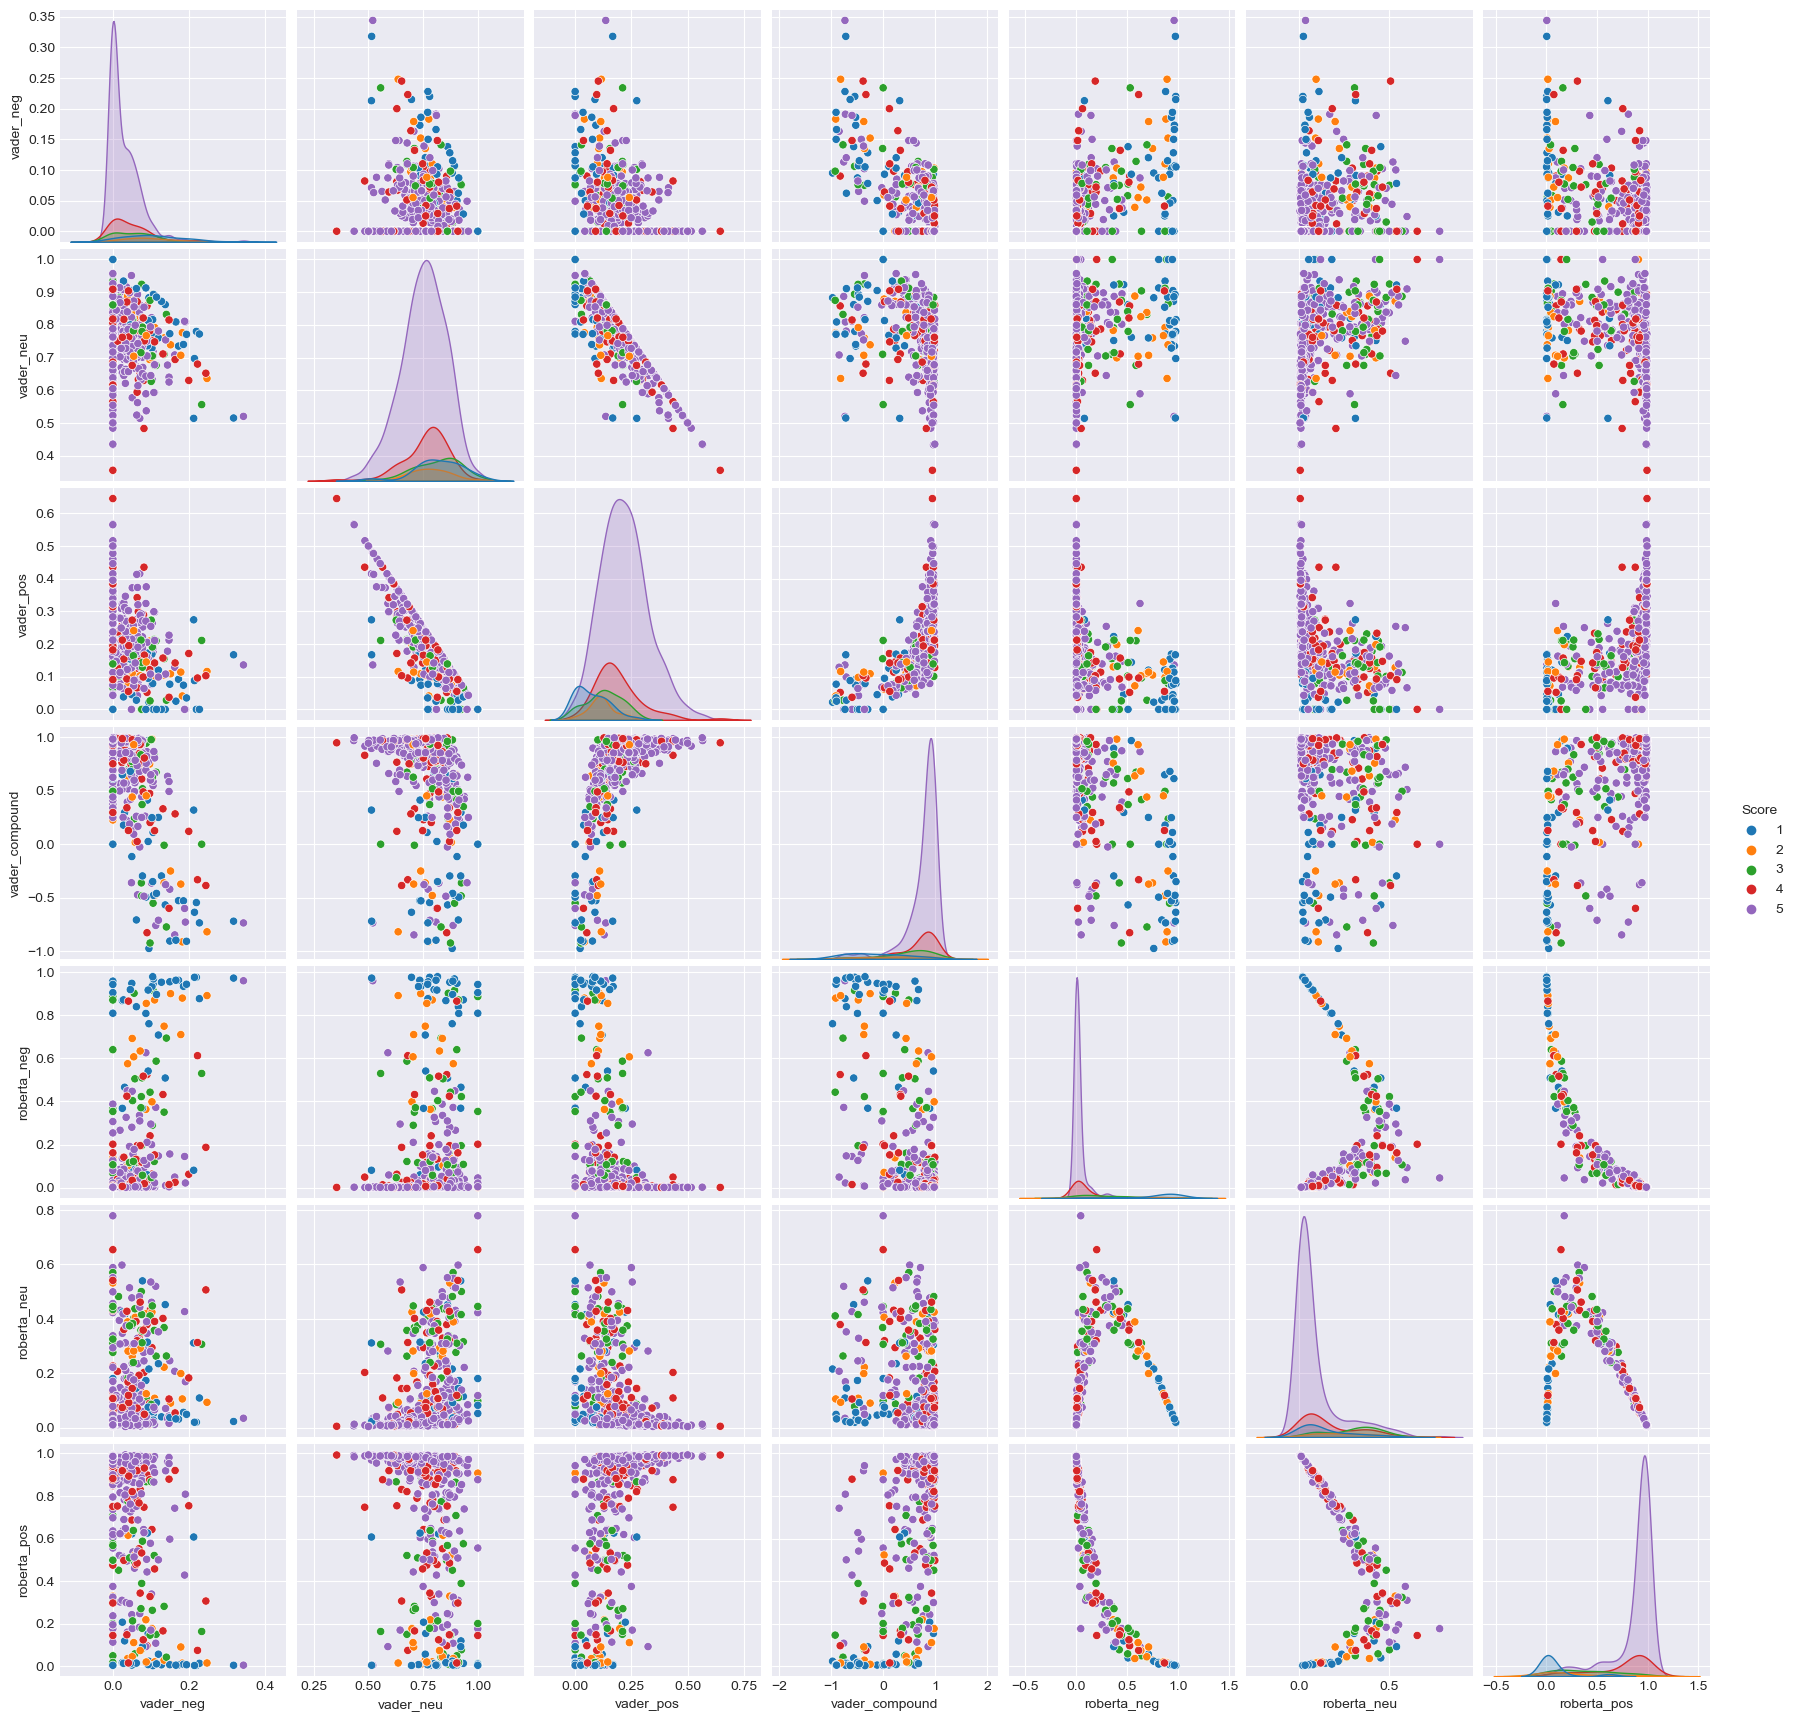

In [29]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
                   'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue="Score",
             palette="tab10")
plt.show()

### Reviewing some Examples

* Positive 1-Star Review
* Negative 5-Star Review

In [30]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [31]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [32]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [33]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'